# Oracular algorithms: Deutsch-Jozsa & Bernstein-Vazirani

Oracular problems are useful concept in complexity theory. We will be interested in using them to compare speeds of classical and quantum algorithms for the same problem. We will consider both Deutsch-Jozsa algorithm (1992) and Bernstein-Vazirani algorithm (1997) which show that in some particular cases, quantum algorithms can be much faster then the best classical ones. Tshow this we will first have a look at oracles.

In [75]:
import qiskit
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from random import randint
from math import pi

dim = 4
## You can use qreg and creg as global variables
qreg = qiskit.QuantumRegister(dim + 1)
creg = qiskit.ClassicalRegister(dim)

simulator = qiskit.Aer.get_backend("qasm_simulator")
statevector = qiskit.Aer.get_backend('statevector_simulator')

## Oracle

Oracles are widely used abstract concepts that can be used to test the validity of our algorithms - allowing them to have some powerful property (possibly breaking achievable bounds) we can have a look how our algorithms stand against such changes. On the other hand, oracles can be also considered as black boxes performing computations that are unavailable to us and might be running for considerable times. There is, naturally a good overlap of the two views, but we will be focussing on the latter.

For us an oracle is an unknown function $f$. In this notebook we will deal only with Boolean functions which map
$$ f: \{1, 2,\ldots, N\} \to \{0, 1\}. $$
Our tasks are to estimate some of its properties in the least number of calls to $f$.

In the *Bernstein-Vazirani* setting we are considering a class of Boolean functions:
$$ f_s(x) = s \cdot x \mod 2, $$
where symbol $\cdot$ represents bitwise product. Our task is to find the $s$ with the number of calls to $f$ being minimal. The size of the domain will be $N = 2^d$, where $d$ will be the number of bits or qubits.

**In the classical case** we need to find $d$ bits of $s$ and for that we need (at least) $d$ queries to the oracle. Namely we can "ask" what is the $j$-th bit of $s$ by inputing $x = 2^j$.

**In the quantum case** we first need to adapt the oracle to the quantum environment, but afterwards, only one query to the (quantum) oracle is enough to find $s$. Let us first turn our attention toi the quantum oracle $U_f$.

Before going further let us define few useful transformation functions:

In [76]:
def bin_str(num, dim=0):
    """
    Returns binary representation of num (int) as a string with optional
    parameter dim to fill with zeroes from left up to length dim.
    """
    return f"{num:0{dim}b}"

def bin_digits(num, dim=0):
    """
    Returns binary representation of num (int) as a list of ints with optional
    parameter dim to fill with zeroes from left up to length dim.
    """
    return [int(c) for c in bin_str(num, dim)]

### Quantum oracle

We already know that quantum evolutions (and thus computation) has to be a reversible process. To be able to do that, it is enough to add additional system that will hold the computed information. Standard way of defining such quantum oracle is
$$ U_f|x\rangle\otimes|m\rangle = |x\rangle\otimes|m \oplus f(x)\rangle. $$
Where the second system is of appropriate dimension and $|m\rangle$ is some state of this system. Naturally, this oracle possesses no more information than $f$ does, but its ability to act on quantum systems (and superpositions in particular) makes the difference.

For boolean functions the second system is just an additional qubit. In many algorithms it is favorable to make the action of the oracle affect the phase (as phases are very good in eliminating unfavorable results) in front of selected states. Very often this desired action is
$$ R_f|x\rangle = (-1)^{f(x)}|x\rangle. $$
This does not seem to be much but when considering superpositions it has consequences. For example a single qubit identity function acting on states $|0\rangle$ or $|1\rangle$ does nothing (except adding a phase in front of $|1\rangle$) but it changes state $|+\rangle$ to $|-\rangle$. Indeed
$$ R_f\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = \frac{1}{\sqrt{2}}\left[(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle\right]
=\frac{1}{\sqrt{2}}(|0\rangle -|1\rangle) = |-\rangle.$$

How to achieve this functioning of the quantum oracle $R_f$ using the quantum oracle $U_f$? It is simple when you start with $|m\rangle = |-\rangle$.

**Task 10.1**: Using previous description define a Bernstein-Vazirani oracle (method `qoracle()`). We want it to act as
$$ U_s|x\rangle = (-1)^{s\cdot x \mod 2}|x\rangle. $$
To achieve this, you need to
- make use of the additional qubit as described above,
- find a way of computing $s\cdot x\mod 2$ on this qubit - you do not need more than a few CNOT gates,
- return the state of the additional qubit to the state $|0\rangle$

In [77]:
class BVoracle:
    """
    Implements Bernstein-Vazirani oracle
    
    Attributes
    ----------
    dim: int
        number of (qu)bits that are used
    ccalls: int
        number of calls performed on the classical oracle
    qcalls: int
        number of calls performed on the quantum oracle
        
    Methods
    -------
    get(x)
        returns x.s mod 2
    qoracle(qreg)
        returns the oracle circuit on qreg
    creset()
        resets the count of ccalls
    qreset()
        resets the count of qcalls
    """
    
    def __init__(self, dim, num=None):
        """
        Parameters
        ----------
        dim: int
            number of (qu)bits that are used
        num: Optional[int]
            initializes s = num, otherwise s is chosen randomly
        """
        if num == None:
            num = randint(0, 2 ** dim - 1)
        ## Private attribute only God knows
        self._num = num
        self.dim = dim
        self.ccalls = 0
        self.qcalls = 0
        
    def get(self, x):
        """
        returns f(x)
        
        Parameters
        ----------
        x: List[int]
            evaluated input value for the f(x)
        """
        assert len(x) == self.dim
        ## ccalls increases every time one queries the oracle
        self.ccalls += 1
        res = 0
        s = bin_digits(self._num, self.dim)
        for i in range(self.dim):
            res += x[i] * s[i]
        return res % 2
    
    ## Assuming that when one calls the qoracle to be created
    ## dim is correctly stated
    def qoracle(self, qreg):
        """
        returns Qiskit circuit representing quantum oracle
        
        Parameters
        ----------
        qreg:
            qiskit quantum register
        """
        
        ## qcalls increases every time one queries the oracle
        self.qcalls += 1
        oracle = qiskit.QuantumCircuit(qreg)
        
        ## Write here your code for the BV quantum oracle.
        ## As a hint you need to
        ## 1. prepare the additional qubit as described above,
        oracle.x(self.dim)
        oracle.h(self.dim)

        ## 2. compute s.x mod 2 on this qubit
        for i, c in enumerate(bin_digits(self._num)):
            if c:
                oracle.cx(self.dim - i - 1, self.dim)

        ## 3. return the state of the additional qubit to the state |0>
        oracle.h(self.dim)
        oracle.x(self.dim)

        return oracle
    
    def creset(self):
        """
        resets the count of ccalls
        """
        self.ccalls = 0
        
    def qreset(self):
        """
        resets the count of qcalls
        """
        self.qcalls = 0

Let us test the classical oracle first.

**Task 10.2:** Write a function that finds $s$ of the Bernstein-Vazirani (classical) oracle `bv` passed as an argument of the function.

In [78]:
def classical(bv):
    b = ""
    for num in range(bv.dim):
        x = bin_digits(2 ** num, bv.dim)
        b += str(bv.get(x))
    return b[::-1]

Let us initialize the oracle first.

In [79]:
bv = BVoracle(dim)

These are the results of the classical querying:

In [80]:
bv.creset()
print(f"The oracle was initialized with bit string s = \"{bin_str(bv._num, bv.dim)}\" [This information is not available to us in general]")
print(f"Your algorithm has found s = \"{classical(bv)}\"")
print(f"Classical oracle was called {bv.ccalls} times.")

The oracle was initialized with bit string s = "0001" [This information is not available to us in general]
Your algorithm has found s = "0001"
Classical oracle was called 4 times.


## Bernstein-Vazirani algorithm

For the quantum oracle we need to prepare a larger circuit first. The circuit is, however, rather simple. We just need to:
1. Prepare a complete superposition of all states
$$ |\psi\rangle = \frac{1}{\sqrt{2^d}}\sum_{j=0}^{2^d-1}|j\rangle,$$
2. Apply the Bernstein-Vazirani oracle on this state,
3. Use the reverse transformation to the one from point 1,
4. Measure the system and return the outcome as a guess of $s$.

**Task 10.3:** Prepare the full Bernstein-Vazirani circuit as defined above.

In [81]:
def quantum(bv):
    circ = qiskit.QuantumCircuit(qreg, creg)

    ## Prepare the full Bernstein-Vazirani circuit as defined above.
    ## Use the following steps:

    ## 1. Prepare a complete superposition of all states
    for i in range(bv.dim):
        circ.h(i)
        
    circ.barrier()

    ## 2. Apply the Bernstein-Vazirani oracle "bv" on this state,
    circ += bv.qoracle(qreg)

    circ.barrier()
    
    ## 3. Use the reverse transformation to the one from point 1
    for i in range(bv.dim):
        circ.h(i)

    ## 4. Measure the system (the outcome shall correspond to s).
    for i in range(bv.dim):
        circ.measure(i, i)

    job = qiskit.execute(circ, simulator, shots=1)
    return list(job.result().get_counts().keys())[0], circ

These are the results of the quantum querying:

The oracle was initialized with bit string s = "0001" [This information is not available to us in general]
Your algorithm has found s = "1000"
Quantum oracle was called 1 time.


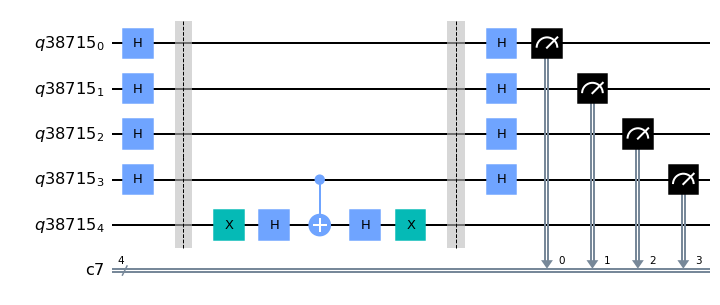

In [82]:
bv.qreset()
guess, circ = quantum(bv)
print(f"The oracle was initialized with bit string s = \"{bin_str(bv._num, bv.dim)}\" [This information is not available to us in general]")
print(f"Your algorithm has found s = \"{guess}\"")
print(f"Quantum oracle was called {bv.qcalls} time.")
circ.draw(output="mpl")

## Deutsch-Jozsa

Deutsch-Jozsa is a variant of Bernstein-Vazirani algorithm. Whereas in BV algorithm we were guessing the oracle parameter $s$, in Deutsch-JOzsa algorithm we are promissed that the function $f$ is one of two kinds:
- *balanced:* returns `0` for exactly half of inputs and `1` for the other half
- *constant:* always returns either `0` or `1`

The algorithm is the same as in Bernstein-Vazirani, and what changes is the oracle and the outputs interpretation:
- for constant function the evolution leads back to state $|00\ldots 0\rangle$
- for balanced function there will be always at least one `1` present in the output.

For example DJ oracle can be following (this is one of many ways of defining it). It is based on the Nernstein-Vazirani oracle with some changes. Firstly, we have a switch `balanced` which, if not provided, will be chosen randomly.

In [27]:
class DJoracle(BVoracle):
    """
    Implements Deursch-Jozsa oracle
    
    Attributes
    ----------
    dim: int
        number of (qu)bits that are used
    ccalls: int
        number of calls performed on the classical oracle
    qcalls: int
        number of calls performed on the quantum oracle
        
    Methods
    -------
    get(x)
        returns x.s mod 2
    qoracle(qreg)
        returns the oracle circuit on qreg
    creset()
        resets the count of ccalls
    qreset()
        resets the count of qcalls
    """
    def __init__(self, dim, balanced=None):
        """
        Parameters
        ----------
        dim: int
            number of (qu)bits that are used
        balanced: Optional[bool]
            initializes either constant (0) or balanced (1) function
        """
        if balanced == None:
            balanced = randint(0, 1)
        ## Private attribute only God knows
        self._balanced = balanced
        self.ccalls = 0
        self.qcalls = 0
        self.dim = dim
        ## Randomly chooses variant
        ## (selects only from a subset of possibilities)
        ##  - _num acts in the same way as in the BVoracle
        ##  - _seed defines post-processing action on the
        ##    additional qubit (in constant case it defines
        ##    the value the function f returns)
        if balanced: # balanced
            self._num = randint(1, 2 ** dim - 1)
            self._seed = 0
        else: # constant
            self._num = 0
            self._seed = randint(0, 1)
        
    def get(self, x):
        """
        returns x.s mod 2
        
        Parameters
        ----------
        x: int
            evaluated input value for the f(x)
        """
        self.ccalls += 1
        res = 0
        s = bin_digits(self._num, self.dim)
        for i in range(self.dim):
            res += x[i] * s[i]
        return (res + self._seed) % 2
    
    ## Assuming that when one calls the qoracle to be created
    ## dim is correctly stated
    def qoracle(self, qreg):
        """
        returns Qiskit circuit representing quantum oracle
        
        Parameters
        ----------
        qreg:
            qiskit quantum register
        """
        
        ## qcalls increases every time one queries the oracle
        self.qcalls += 1
        oracle = qiskit.QuantumCircuit(qreg)
        
        oracle.x(self.dim)
        oracle.h(self.dim)

        for i, c in enumerate(bin_digits(self._num, dim)):
            if c:
                oracle.cx(self.dim - i - 1, self.dim)
                
        if self._seed:
            oracle.x(dim)

        oracle.h(self.dim)
        oracle.x(self.dim)

        return oracle
    
    def creset(self):
        """
        resets the count of ccalls
        """
        self.ccalls = 0
        
    def qreset(self):
        """
        resets the count of qcalls
        """
        self.qcalls = 0

**Task 10.4:** define a classical procedure querying the oracle in as few steps as possible and finding whether $f$ is constant (`0`) or balanced (`1`).

In [28]:
def cevaluate(dj):
    ## Write a function that classically (using get) determines
    ##  - if the oracle dj is constant and returns 0
    ##  - if the oracle dj in balanced and returns 1
    zeros = 0
    total = 0
    for x in range(2 ** dj.dim):
        out = dj.get(bin_digits(x, dj.dim))
        
        if out == 0:
            zeros += 1
        total += 1

        ## If we find at least one different digit,
        ## the function must be balanced
        if zeros != 0 and zeros != total:
            return 1

        ## If we have found more than half of total
        ## inputs leading to the same outcome
        ## the function must be constant
        if total > 2 ** (dj.dim - 1):
            return 0
        


These are the results of the classical querying:

In [87]:
runs = 1000
correct = 0
calls = 0
for _ in range(runs):
    dj = DJoracle(dim)
    if cevaluate(dj) == dj._balanced:
        correct += 1
    calls += dj.ccalls
print(f"You correctly guessed the function type in {100 * correct / runs}% of runs")
print(f"The average number of oracle calls was {calls / runs:.2f}")

You correctly guessed the function type in 100.0% of runs
The average number of oracle calls was 6.17


**Task 10.5:** program a quantum procedure querying the oracle once to find whether $f$ is constant (`0`) or balanced (`1`).

In [89]:
def qevaluate(dj):
    circ = qiskit.QuantumCircuit(qreg, creg)

    ## Prepare the full Deutsch-Jozsa circuit as defined above.
    ## Use the following steps:

    ## 1. Prepare a complete superposition of all states
    for i in range(dj.dim):
        circ.h(i)
        
    circ.barrier()

    ## 2. Apply the Bernstein-Vazirani oracle "bv" on this state,
    circ += dj.qoracle(qreg)
    
    circ.barrier()

    ## 3. Use the reverse transformation to the one from point 1
    for i in range(dj.dim):
        circ.h(i)

    ## 4. Measure the system (the outcome containing 1 should be for balanced functions).
    ## and deduce whether the function is constant (0) or balanced (1)
    for i in range(dj.dim):
        circ.measure(i, i)

    job = qiskit.execute(circ, simulator, shots=1)
        
    if "1" in list(job.result().get_counts().keys())[0]:
        return 1, circ
    return 0, circ

These are the results of the quantum querying:

In [90]:
runs = 1000
correct = 0
calls = 0
for _ in range(runs):
    d = DJoracle(dim)
    if qevaluate(d)[0] == d._balanced:
        correct += 1
    calls += d.qcalls
print(f"You correctly guessed the function type in {100 * correct / runs}% of runs")
print(f"The average number of oracle calls was {calls / runs:.2f}")

You correctly guessed the function type in 100.0% of runs
The average number of oracle calls was 1.00


You should always get the correct result in one quantum oracle call.

Now you can have a look at the circuit with constant oracle.

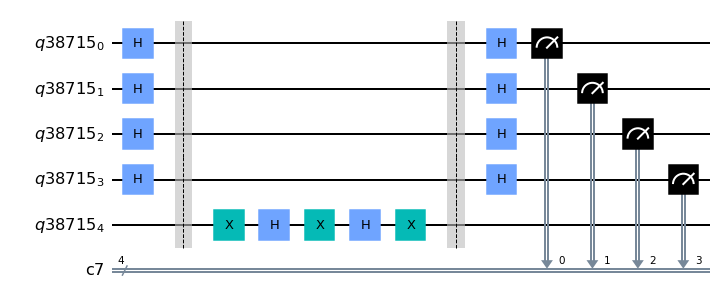

In [91]:
qevaluate(DJoracle(dim, 0))[1].draw(output="mpl")

And here is the circuit with balanced oracle.

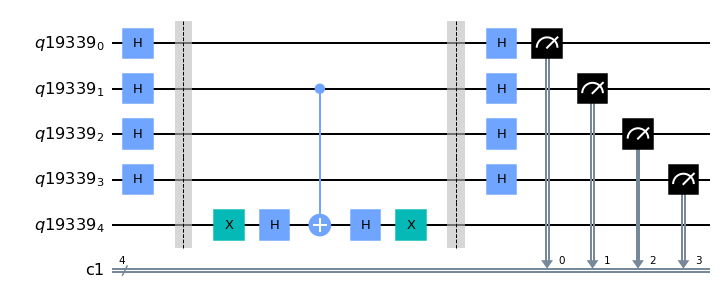

In [33]:
qevaluate(DJoracle(dim, 1))[1].draw(output="mpl")

*Note: If you have done everything correctly, you should be able to guess everything correctly with 100%. While in quantum cases you always need only one step, in classical cases this number will be higher - `dim`-times in the BV case and for the DJ case roughly*

In [93]:
print(f"{2 ** (dim - 2) + 2:.2f}-times")

6.00-times
